# Fuzzy Music Genre Clustering (with C-Means)

Fuzzy C-Means clustering is a good fit for music genre clustering. Music is an art form, fluent and even with words difficult to describe in full. A song can have influences from many different genres. Fuzzy clustering allows for this, as the dataset must not be split crisply into categories, a song can belong to multiple genres in different degrees.

Of course for this notebook is based on the [tutorial notebook](./02_FuzzyClustering.ipynb) with sections integrated here without change.

# Important Note:

The SQLite database of this dataset exceeds the file size limit of github. For running this notebook, please download the database from [this link](http://labrosa.ee.columbia.edu/~dpwe/tmp/lastfm_tags.db) and add it in the folder `03_data_last_fm` with the filename `lastfm_tags.db`.

# Public Dataset Used

The dataset analysed in this notebook is the Last.fm Dataset, which is part of Million Song Dataset and its official song tag and song similarity dataset, available at their [website](http://millionsongdataset.com/lastfm/).

The analysis is based on the tags of the Last.fm dataset. The tags describe the genre attributed to a song. It includes a weight between 0 and 100 for the attributed tags.


## Dataset Citation

Bertin-Mahieux T., Ellis D., Whitman B., & Lamere P. (2011). The Million Song Dataset. *Proceedings of the 12th International Conference on Music Information.* ISMIR. https://ismir2011.ismir.net/ISMIR2011_complete_proceedings.pdf


# Method Overview

The goal is to condense the user-created (users of last.fm) tags to clusters of 'super-genres' to condense the dataset to a more digestible number of clusters. 

For performance reasons, only a subset of the Last.fm Dataset will be used in this notebook. The code shall be organized such that the full dataset could be used as input (theoretically). The n first songs in the dataset which have tags are used, with n being equal to the sum of the size of train and test set.

## Train / Test Split

The data is split into a train and a test subset. The test set will be used for applying the trained model for prediction. No supervision is implemented in this notebook as the data is unlabelled (super-genres are the output of this notebook, so no labelled test-set can already exist).

## Creation of the Feature Space

A list of the most popular tags is published in the dataset. The n most popular tags are used to create a n-dimensional feature space.

*Note: The list of most popular tags is based on the entire dataset.*

## Determining the number of clusters

The Fuzzy Partition Coefficient (FPC) will be used to determine a 'good' number of clusters.

# User Parameter

In [173]:
N_FEATURE_SPACE = 100
SIZE_TRAIN = 1000
SIZE_TEST = 1000

# Imports and File IO

In [174]:
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz


PATH_DATA = Path('03_data_last_fm')
PATH_DB = PATH_DATA / 'lastfm_tags.db'



# Feature Space

In [175]:
df_unique_tags = pd.read_csv(PATH_DATA / 'lastfm_unique_tags.txt', sep='\t', header=None, names=['Tag', 'Count'])
print(df_unique_tags[:N_FEATURE_SPACE])

                Tag   Count
0              rock  101071
1               pop   69159
2       alternative   55777
3             indie   48175
4        electronic   46270
..              ...     ...
95              USA    8725
96            2000s    8671
97  Favourite Songs    8661
98              emo    8622
99               UK    8616

[100 rows x 2 columns]


# Data Import

This for sure could be done more nicely taking advantage of the SQLite database. Unfortunately my insufficient SQLite knowledge is pushing me towards a quick and dirty solution (deadline is tonight).

The SQLite queries are taken from the demo file available on the dataset website (or as a copy in the file [LastFmSqLiteDemoTags.ipynb](./LastFmSqLiteDemoTags.ipynb)).

In [176]:
# SQLite Database
sql_conn = sqlite3.connect(PATH_DB)

# Understand database
# print(pd.read_sql_query('SELECT * FROM sqlite_master', sql_conn))

# Get all tracks with at least one tag
df_tagged_tracks = pd.read_sql_query('SELECT tid FROM tids', sql_conn)

header_feature_vectors = ['Tag Id']
header_feature_vectors.extend(list(df_unique_tags['Tag'][:N_FEATURE_SPACE]))

df_feature_vectors = pd.DataFrame(columns=header_feature_vectors)


for i, tid in df_tagged_tracks.itertuples():
    # Get all tags (with value) for track tid
    sql = "SELECT tags.tag, tid_tag.val FROM tid_tag, tids, tags WHERE tags.ROWID=tid_tag.tag AND tid_tag.tid=tids.ROWID and tids.tid='%s'" % tid
    df_tid = pd.read_sql_query(sql, sql_conn)
    
    row = [tid] + [0] * N_FEATURE_SPACE
    df_feature_vectors.loc[i] = row

    for _, tag, val in df_tid.itertuples():
        if tag in df_feature_vectors.columns[1:]:
            df_feature_vectors.at[i, tag] = val

    if i >= (SIZE_TRAIN + SIZE_TEST) - 1:
       break
        
sql_conn.close()

print(df_feature_vectors)

                  Tag Id  rock  pop  alternative  indie  electronic  \
0     TRCCCYE12903CFF0E9     0    0            0      0           0   
1     TRCCCFH12903CEBC70     0    0            0      0           0   
2     TRCCCJT128F429FFF6     0  100            0      0           0   
3     TRCCCBJ128F4286E6F     0    0            0      0           0   
4     TRCCJTI128EF35394A     0    0            0      0           0   
...                  ...   ...  ...          ...    ...         ...   
1995  TRCKUQE128F42577F3     0    0            0      0           0   
1996  TRCKVSE128F42887DF     0   50            0      0           0   
1997  TRCKVSV128F92F34F7     0    0            0      0           0   
1998  TRCKVUV12903CF0F54     0    0            0      0           0   
1999  TRCKVEX128F9334F2A     0    0            0      0           0   

      female vocalists  favorites  Love  dance  ...  epic  Ballad  \
0                    0          0     0      0  ...     0       0   
1        

# Clustering

Different numbers of clusters are tried as we don't know how many clusters are appropriate.

In [177]:
# Set up the loop and plot
fpcs = []
range_centers = range(2, 102)

for ncenters in range_centers:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        df_feature_vectors[:SIZE_TRAIN].drop('Tag Id', axis=1).transpose(), ncenters, m=2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

# The fuzzy partition coefficient (FPC)

The FPC is defined on the range from 0 to 1, with 1 being best. It is a metric which tells us how cleanly our data is described by a certain model. Next we will cluster our set of data - which we know has three clusters - several times, with between 2 and 9 clusters. We will then show the results of the clustering, and plot the fuzzy partition coefficient. When the FPC is maximized, our data is described best.


Text(0, 0.5, 'Fuzzy partition coefficient')

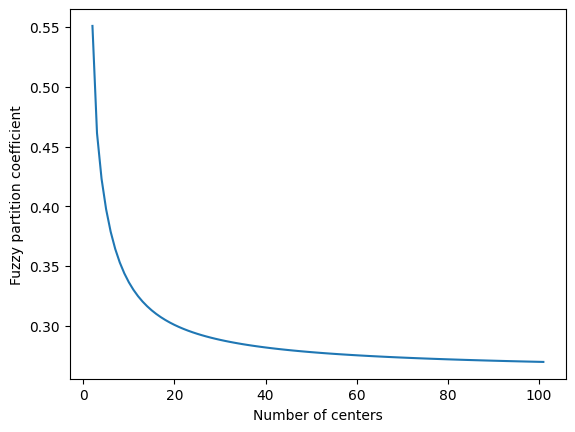

In [178]:
fig2, ax2 = plt.subplots()
ax2.plot(range_centers, fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

# Interpretation

Interestingly, the clearly best result, even if still with a mediocre FPC, is splitting the data into two clusters only. The following sections aim at interpreting the clusters with the number of clusters equal to 2.

In [179]:
# Regenerating model with 2 clusters
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        df_feature_vectors[:SIZE_TRAIN].drop('Tag Id', axis=1).transpose(), c=2, m=2, error=0.005, maxiter=1000, init=None)

print('Three highest score dimensions for each cluster center:')
print('Indices: 0 is the globally most used tag, 99 the globally least used tag in the top 100 tags')
center = np.array(cntr)
sorted_index_center = np.argsort(center)

print(len(center[0]))
print('')
print('Cluster 0:')
print('Indices: ', sorted_index_center[0, -3:])
print('Tags: ') 
for i in sorted_index_center[0, -3:]:
    print('  ', df_unique_tags.at[i, 'Tag'])
print('')

print('Cluster 1:')
print('Indices: ', sorted_index_center[1, -3:])
print('Tags: ') 
for i in sorted_index_center[1, -3:]:
    print('  ', df_unique_tags.at[i, 'Tag'])


Three highest score dimensions for each cluster center:
Indices: 0 is the globally most used tag, 99 the globally least used tag in the top 100 tags
100

Cluster 0:
Indices:  [11  1  0]
Tags: 
   jazz
   pop
   rock

Cluster 1:
Indices:  [11  1  0]
Tags: 
   jazz
   pop
   rock


## ... Interpretation

The three highest scoring dimensions in both clusters are the same! Indeed, clusters are allowed to overlap with the fuzzy kMeans. All three top dimensions are also very popular tags in the whole dataset, which makes sense.

Let's try this again: Which are the three highest-scoring dimensions *which are different* between the two clusters?

In [180]:
sorted_differing_dimensions = sorted_index_center[0] != sorted_index_center[1]

print('Differing dimensions: ')
print(sorted_differing_dimensions)

print('')
print('Three highest score dimensions different between cluster centers:')
print('Indices: 0 is the globally most used tag, 99 the globally least used tag in the top 100 tags')
center = np.array(cntr)
sorted_index_center = np.argsort(center)

print('')
print('Cluster 0:')
print('Indices: ', sorted_index_center[0, -11:-8])
print('Tags: ') 
for i in sorted_index_center[0, -11:-8]:
    print('  ', df_unique_tags.at[i, 'Tag'])
print('')

print('Cluster 1:')
print('Indices: ', sorted_index_center[1, -11:-8])
print('Tags: ') 
for i in sorted_index_center[1, -11:-8]:
    print('  ', df_unique_tags.at[i, 'Tag'])

Differing dimensions: 
[False False  True  True  True  True False  True False  True  True  True
 False False  True  True False False  True  True False  True  True  True
  True  True  True False False  True  True  True  True  True  True  True
  True False  True  True False  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
 False  True  True False  True  True  True  True  True  True  True  True
  True False  True  True False False  True  True  True  True  True False
  True  True  True False  True  True  True  True False False False False
 False False False False]

Three highest score dimensions different between cluster centers:
Indices: 0 is the globally most used tag, 99 the globally least used tag in the top 100 tags

Cluster 0:
Indices:  [ 8 24 19]
Tags: 
   dance
   folk
   soul

Cluster 1:
Indices:  [24 19  8]
Tags: 
   folk
   soul
   dance


## ... Interpretation

The only thing changing is the order, they are exactly the same tags, once again.

It seems like the two cluster centers are really close together.

And with a look at the [documentation](https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html#skfuzzy.cluster.cmeans) a note confirms this hypothesis:

*"Fuzzy C-Means has a known problem with high dimensionality datasets, where the majority of cluster centers are pulled into the overall center of gravity. If you are clustering data with very high dimensionality and encounter this issue, another clustering method may be required. For more information and the theory behind this, see Winkler et al."*

The documentation itself cites this passage from the following source:

Winkler, R., Klawonn, F., & Kruse, R. Fuzzy c-means in high dimensional spaces. 2012. Contemporary Theory and Pragmatic Approaches in Fuzzy Computing Utilization, 1.


A final question this notebook will answer is the size of the two clusters found. For this, the membership are hardened by taking the max value to crisply attribute the songs to cluster 0 or 1.

In [188]:
cluster_assignments = np.argmax(u, axis=0)
size_cluster1 = np.sum(cluster_assignments)
size_cluster0 = SIZE_TRAIN - size_cluster1

print('Size of cluster 0: ', size_cluster0)
print('Size of cluster 1: ', size_cluster1)

Size of cluster 0:  611
Size of cluster 1:  389


## ... Interpretation

The two clusters are similarly sized, supporting the theory above that both cluster centers are pulled into the overall center of gravity due to the high dimensionality.

# Conclusion

In conclusion, it does not make much sense trying to classify new data based on this very flawed model. Re-running the fuzzy k-Means on the top 10 most used tags or even the top 5 most used tags does not change the outcome of a FPC that resembles a negative exponential function, as seen above plotted for a 100-dimensional feature space.

It is re-assuring that the theory from Winkler et al., referred to by the scikit-fuzzy documentation, does come to the same conclusion as this practical experiment here.

Another algorithm should be used to find better super-genres for this music dataset, fuzzy kMeans is not a good fit.
